<a href="https://colab.research.google.com/github/michaelvyaho/course_poo/blob/main/BacktestorIndex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

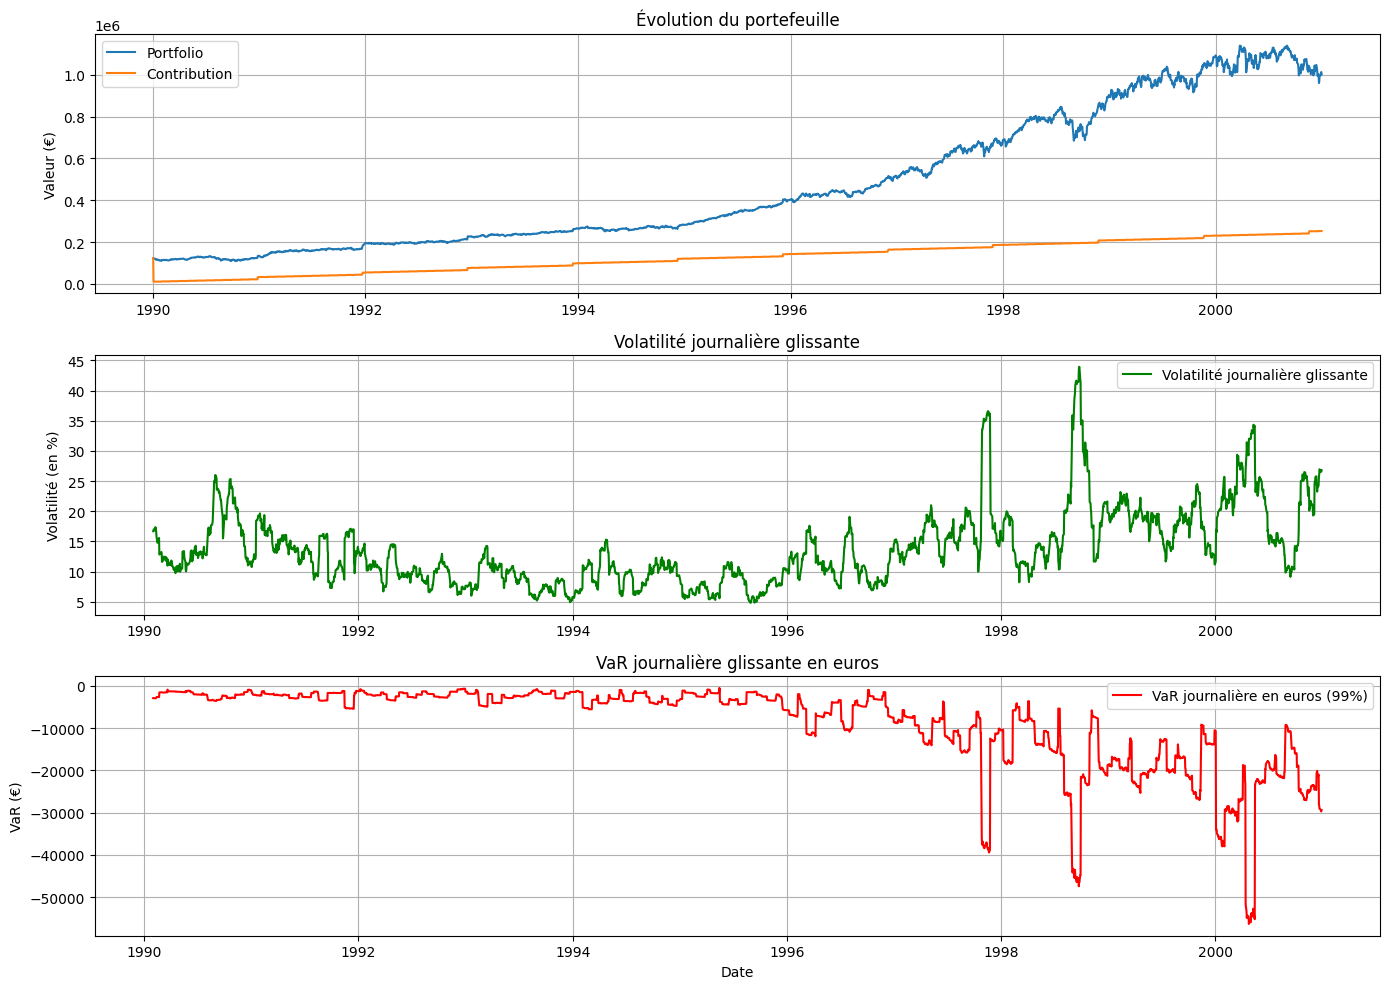

In [57]:
# file: backtesting_index_yahoo_daily.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


class BacktestingIndex:
    def __init__(self, initial_investment: float, monthly_contribution: float,annual_contribution: float, confidence: float):
        """
        Initialise les paramètres du portefeuille.

        Args:
            initial_investment (float): Montant initial investi.
            monthly_contribution (float): Contribution mensuelle additionnelle.
            confidence (float): Niveau de confiance pour le calcul de la VaR (ex: 0.95 pour 95%).
        """
        self.initial_investment = initial_investment
        self.monthly_contribution = monthly_contribution
        self.annual_contribution = annual_contribution
        self.confidence = confidence
        self.data = None
        self.portfolio = None

    def get_ticker(self):
        return self.ticker

    def load_data(self, ticker: str, start_date: str, end_date: str):
        """
        Récupère les données historiques de l'indice depuis Yahoo Finance.

        Args:
            ticker (str): Symbole Yahoo Finance (ex: '^GSPC' pour le S&P 500).
            start_date (str): Date de début (format 'YYYY-MM-DD').
            end_date (str): Date de fin (format 'YYYY-MM-DD').
        """
        # Récupère les données depuis Yahoo Finance
        self.data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        self.data = self.data[['Adj Close']].rename(columns={'Adj Close': 'Close'})

        # Calcul des rendements journaliers
        self.data['Returns'] = self.data['Close'].pct_change()

    def simulate_portfolio(self):
        """
        Simule l'évolution du portefeuille en tenant compte
        des investissements mensuels.
        """
        investment = self.initial_investment
        portfolio_value = [investment]
        contribution_value = [investment]
        global_contibution=[investment]
        days_per_month = 21  # Approximatif : 21 jours de bourse par mois
        days_per_year = 250  # Approximatif : 250 jours de bourse par an
        global_investment=self.monthly_contribution+self.annual_contribution

        for i, ret in enumerate(self.data['Returns'][1:], start=1):
            # Ajoute la contribution mensuelle le premier jour de chaque mois
            if i % days_per_month == 0 :
                investment += self.monthly_contribution
                global_investment+=self.monthly_contribution
            elif i % days_per_year == 0:
            # Applique le rendement quotidien
              investment += self.annual_contribution
              global_investment+=self.annual_contribution

            investment *= (1 + ret)
            portfolio_value.append(investment)
            global_contibution.append(global_investment)

        self.data['Portfolio'] = portfolio_value
        self.data['Contribution'] = global_contibution

    def calculate_metrics(self, rolling_window: int = 1):
        """
        Calcule la volatilité glissante et la VaR (journalières).

        Args:
            rolling_window (int): Fenêtre glissante en jours pour le calcul.
        """
        historical_returns = self.data['Returns']

        # Volatilité glissante journalière (écart-type des rendements)
        rolling_volatility = historical_returns.rolling(window=rolling_window).std()*np.sqrt(252)*100
        self.data['Volatility_Daily'] = rolling_volatility

        # VaR journalière en pourcentage (VaR relative)
        rolling_var = historical_returns.rolling(window=rolling_window).apply(
            lambda x: np.percentile(x, 100 * (1 - self.confidence)), raw=True
        )
        self.data['VaR_Daily'] = rolling_var

        # VaR journalière en euros (VaR absolue)
        self.data['VaR_Daily_Euros'] = self.data['VaR_Daily'] * self.data['Portfolio']

    def plot_results(self):
        """
        Affiche les résultats sous forme de graphiques.
        """
        plt.figure(figsize=(14, 10))

        # Graphique du portefeuille
        plt.subplot(3, 1, 1)
        plt.plot(self.data.index, self.data[['Portfolio','Contribution']], label="Valeur du portefeuille")
        plt.legend(['Portfolio','Contribution'])
        plt.title(f"Évolution du portefeuille")
        plt.ylabel("Valeur (€)")
        plt.grid(True)
        #plt.legend()

        # Graphique de la volatilité journalière glissante
        plt.subplot(3, 1, 2)
        plt.plot(self.data.index, self.data['Volatility_Daily'], label="Volatilité journalière glissante", color='green')
        plt.title("Volatilité journalière glissante")
        plt.ylabel("Volatilité (en %)")
        plt.grid(True)
        plt.legend()

        # Graphique de la VaR journalière en euros
        plt.subplot(3, 1, 3)
        plt.plot(self.data.index, self.data['VaR_Daily_Euros'], label=f"VaR journalière en euros ({int(self.confidence * 100)}%)", color='red')
        plt.title("VaR journalière glissante en euros")
        plt.xlabel("Date")
        plt.ylabel("VaR (€)")
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()


# Utilisation de la classe
if __name__ == "__main__":
    # Exemple d'utilisation
    initial=21000+35000+34000+13000+20000
    backtester = BacktestingIndex(initial_investment=initial, monthly_contribution=1000,annual_contribution=10000, confidence=0.99)

    # Chargement des données du S&P 500 depuis Yahoo Finance
    ticker = ["^GSPC"]  # Symbole pour le S&P 500
    backtester.load_data(ticker=ticker, start_date="1990-01-01", end_date="2000-12-31")

    # Simulation du portefeuille et calcul des métriques
    backtester.simulate_portfolio()
    backtester.calculate_metrics(rolling_window=21)  # 21 jours pour une fenêtre mensuelle environ

    # Affichage des résultats
    backtester.plot_results()
